In [17]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 29.3 MB/s eta 0:00:00


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("fatemehmehrparvar/skin-cancer-detection")

print("Path to dataset files:", path)

100%|██████████| 30.5M/30.5M [00:00<00:00, 119MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/fatemehmehrparvar/skin-cancer-detection/versions/1


In [1]:
from glob import glob
from PIL import Image
from torch.utils.data import random_split, Dataset, DataLoader
import os

class CustomDataset(Dataset):
    def __init__(self, root, transformations = None):

        self.transformations = transformations
        self.im_paths = sorted(glob(f"{root}/*/*/*/*/*/*.jpg"))

        self.cls_names, self.cls_counts, count, data_count = {}, {}, 0, 0
        for idx, im_path in enumerate(self.im_paths):
            class_name = self.get_class(im_path)
            if class_name not in self.cls_names: self.cls_names[class_name] = count; self.cls_counts[class_name] = 1; count += 1
            else: self.cls_counts[class_name] += 1

    def get_class(self, path): return os.path.dirname(path).split("/")[-2]

    def __len__(self): return len(self.im_paths)

    def __getitem__(self, idx):

        im_path = self.im_paths[idx]
        im = Image.open(im_path).convert("RGB")
        gt = self.cls_names[self.get_class(im_path)]

        if self.transformations is not None: im = self.transformations(im)

        return im, gt

In [2]:
def get_dls(root, transformations, bs, split = [0.9, 0.05, 0.05], ns = 4):

    ds = CustomDataset(root = root, transformations = transformations)

    total_len = len(ds)
    tr_len = int(total_len * split[0])
    vl_len = int(total_len * split[1])
    ts_len = total_len - (tr_len + vl_len)

    tr_ds, vl_ds, ts_ds = random_split(dataset = ds, lengths = [tr_len, vl_len, ts_len])

    tr_dl, val_dl, ts_dl = DataLoader(tr_ds, batch_size = bs, shuffle = True, num_workers = ns), DataLoader(vl_ds, batch_size = bs, shuffle = False, num_workers = ns), DataLoader(ts_ds, batch_size = 1, shuffle = False, num_workers = ns)

    return tr_dl, val_dl, ts_dl, ds.cls_names

In [4]:
from torchvision import transforms as T

root = "/root/.cache/kagglehub/datasets/fatemehmehrparvar/skin-cancer-detection/versions/1"
mean, std, im_size = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 224
tfs = T.Compose([T.Resize((im_size, im_size)), T.ToTensor(), T.Normalize(mean = mean, std = std)])
tr_dl, val_dl, ts_dl, classes = get_dls(root = root, transformations = tfs, bs = 32)

print(len(tr_dl)); print(len(val_dl)); print(len(ts_dl)); print(classes)

6
1
11
{'melanoma': 0, 'notmelanoma': 1}


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Visualization

In [7]:
import numpy as np
import random
from matplotlib import pyplot as plt

def tensor_2_im(t, t_type = "rgb"):

    gray_tfs = T.Compose([T.Normalize(mean = [ 0.], std = [1/0.5]), T.Normalize(mean = [-0.5], std = [1])])
    rgb_tfs = T.Compose([T.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]), T.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ])])

    invTrans = gray_tfs if t_type == "gray" else rgb_tfs

    return (invTrans(t) * 255).detach().squeeze().cpu().permute(1,2,0).numpy().astype(np.uint8) if t_type == "gray" else (invTrans(t) * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8)

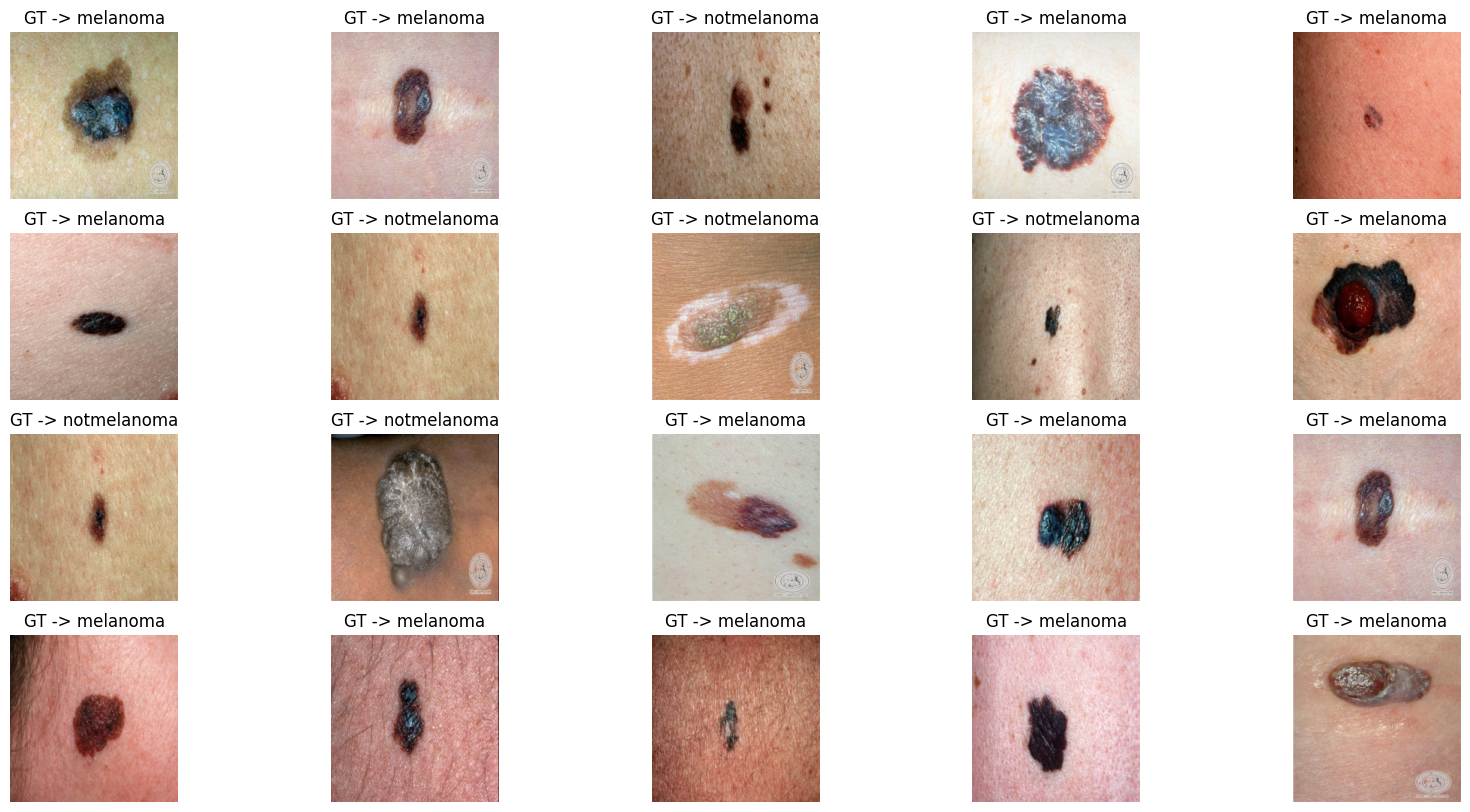

In [8]:
def visualize(data, n_ims, rows, cmap = None, cls_names = None):
    assert cmap in ["rgb", "gray"], "Rasmni oq-qora yoki rangli ekanini aniqlashtirib bering!"
    if cmap == "rgb": cmap = "viridis"

    plt.figure(figsize = (20, 10))
    indekslar = [random.randint(0, len(data) - 1) for _ in range(n_ims)]
    for idx, indeks in enumerate(indekslar):

        im, gt = data[indeks]
        # Start plot
        plt.subplot(rows, n_ims // rows, idx + 1)
        if cmap: plt.imshow(tensor_2_im(im, cmap), cmap=cmap)
        else: plt.imshow(tensor_2_im(im))
        plt.axis('off')
        if cls_names is not None: plt.title(f"GT -> {cls_names[int(gt)]}")
        else: plt.title(f"GT -> {gt}")

visualize(tr_dl.dataset, 20, 4, "rgb", list(classes.keys()))

Analysis

/tmp/ipython-input-1058982592.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cls_names, rotation = 60, size=14)


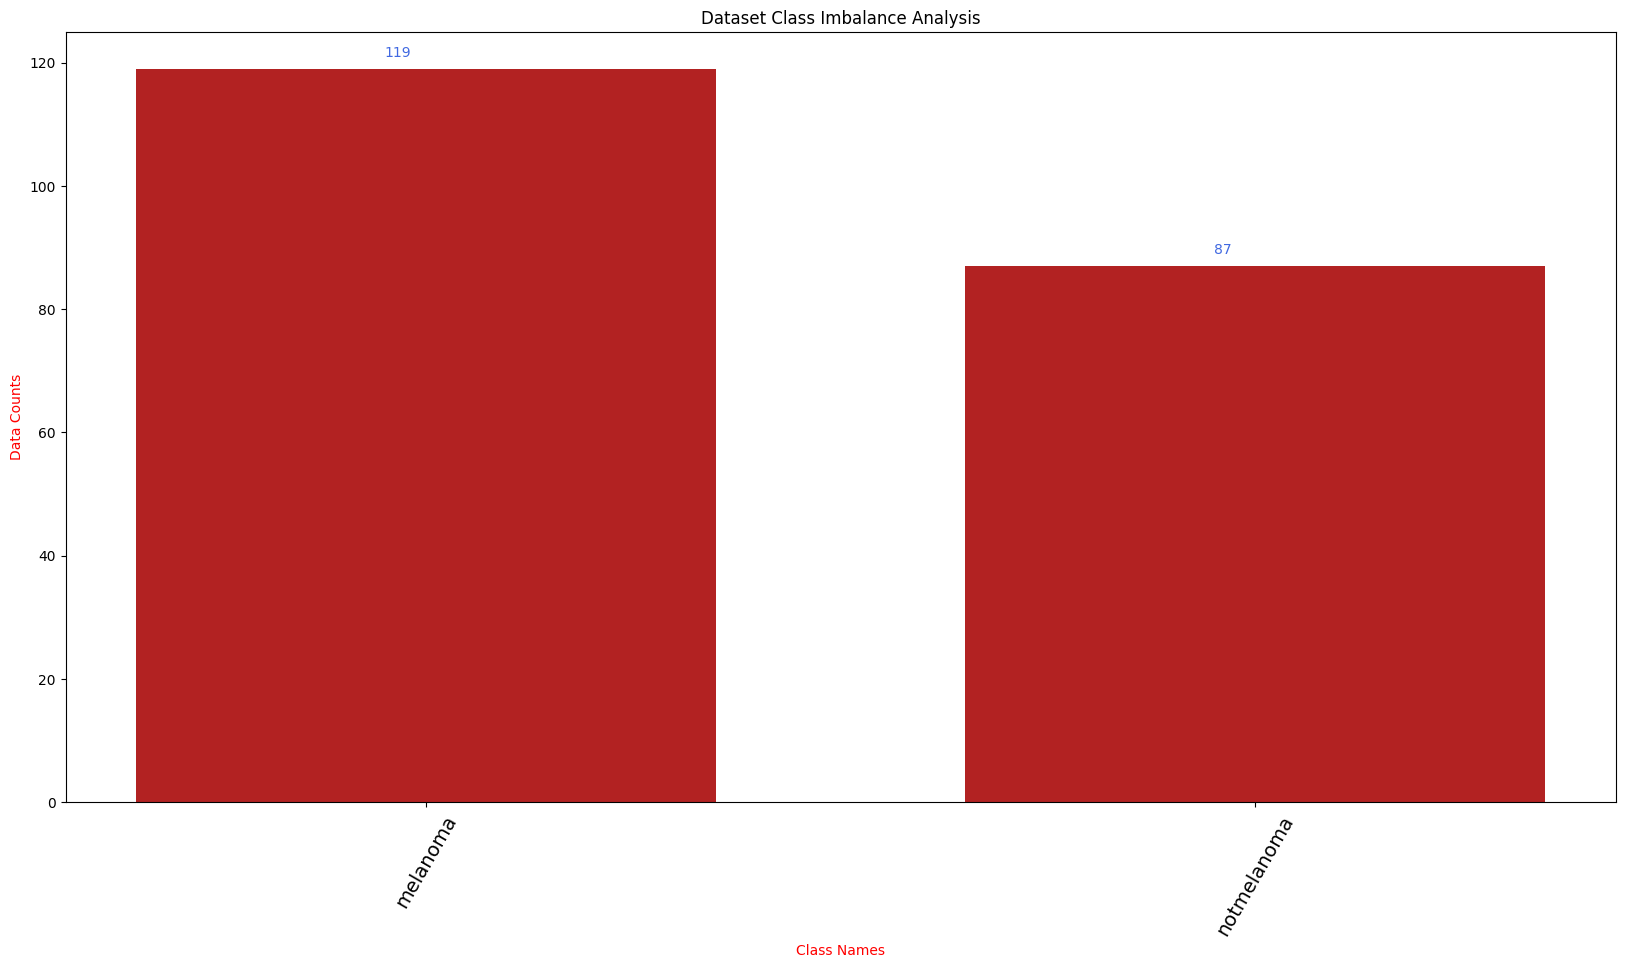

In [15]:
def data_analysis(root, transformations):

    ds = CustomDataset(root = root, transformations = transformations)
    cls_counts, width, text_width = ds.cls_counts,  0.7, 0.05
    text_height = 2
    cls_names = list(cls_counts.keys()); counts = list(cls_counts.values())

    fig, ax = plt.subplots(figsize = (20, 10))
    indices = np.arange(len(counts))

    ax.bar(indices, counts, width, color = "firebrick")
    ax.set_xlabel("Class Names", color = "red")
    ax.set_xticklabels(cls_names, rotation = 60, size=14)
    ax.set(xticks = indices, xticklabels = cls_names)
    ax.set_ylabel("Data Counts", color = "red")
    ax.set_title(f"Dataset Class Imbalance Analysis")

    for i, v in enumerate(counts): ax.text(i - text_width, v + text_height, str(v), color = "royalblue")

data_analysis(root = root, transformations = tfs)

Train model

In [19]:
import timm, torchmetrics, torch
from tqdm import tqdm
m = timm.create_model("rexnet_150", pretrained = True, num_classes = len(classes))

def train_setup(m): return m.to("cuda").eval(), 10, "cuda", torch.nn.CrossEntropyLoss(), torch.optim.Adam(params = m.parameters(), lr = 3e-4)
def to_device(batch, device): return batch[0].to(device), batch[1].to(device)
def get_metrics(model, ims, gts, loss_fn, epoch_loss, epoch_acc, epoch_f1): preds = model(ims); loss = loss_fn(preds, gts); return loss, epoch_loss + (loss.item()), epoch_acc + (torch.argmax(preds, dim = 1) == gts).sum().item(), epoch_f1 + f1_score(preds, gts)

m, epochs, device, loss_fn, optimizer = train_setup(m)

f1_score = torchmetrics.F1Score(task = "multiclass", num_classes = len(classes)).to(device)
save_prefix, save_dir = "cancer", "saved_models"
print("Start training...")
best_acc, best_loss, threshold, not_improved, patience = 0, float("inf"), 0.01, 0, 5
tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s = [], [], [], [], [], []

best_loss = float(torch.inf)

for epoch in range(epochs):

    epoch_loss, epoch_acc, epoch_f1 = 0, 0, 0
    for idx, batch in tqdm(enumerate(tr_dl)):

        ims, gts = to_device(batch, device)

        loss, epoch_loss, epoch_acc, epoch_f1 = get_metrics(m, ims, gts, loss_fn, epoch_loss, epoch_acc, epoch_f1)
        optimizer.zero_grad(); loss.backward(); optimizer.step()

    tr_loss_to_track = epoch_loss / len(tr_dl)
    tr_acc_to_track  = epoch_acc  / len(tr_dl.dataset)
    tr_f1_to_track   = epoch_f1   / len(tr_dl)
    tr_losses.append(tr_loss_to_track); tr_accs.append(tr_acc_to_track); tr_f1s.append(tr_f1_to_track)

    print(f"{epoch + 1}-epoch train process is completed!")
    print(f"{epoch + 1}-epoch train loss          -> {tr_loss_to_track:.3f}")
    print(f"{epoch + 1}-epoch train accuracy      -> {tr_acc_to_track:.3f}")
    print(f"{epoch + 1}-epoch train f1-score      -> {tr_f1_to_track:.3f}")

    m.eval()
    with torch.no_grad():
        val_epoch_loss, val_epoch_acc, val_epoch_f1 = 0, 0, 0
        for idx, batch in enumerate(val_dl):
            ims, gts = to_device(batch, device)
            loss, val_epoch_loss, val_epoch_acc, val_epoch_f1 = get_metrics(m, ims, gts, loss_fn, val_epoch_loss, val_epoch_acc, val_epoch_f1)

        val_loss_to_track = val_epoch_loss / len(val_dl)
        val_acc_to_track  = val_epoch_acc  / len(val_dl.dataset)
        val_f1_to_track   = val_epoch_f1   / len(val_dl)
        val_losses.append(val_loss_to_track); val_accs.append(val_acc_to_track); val_f1s.append(val_f1_to_track)

        print(f"{epoch + 1}-epoch validation process is completed!")
        print(f"{epoch + 1}-epoch validation loss     -> {val_loss_to_track:.3f}")
        print(f"{epoch + 1}-epoch validation accuracy -> {val_acc_to_track:.3f}")
        print(f"{epoch + 1}-epoch validation f1-score -> {val_f1_to_track:.3f}")

        if val_loss_to_track < (best_loss + threshold):
            os.makedirs(save_dir, exist_ok = True)
            best_loss = val_loss_to_track
            torch.save(m.state_dict(), f"{save_dir}/{save_prefix}_best_model.pth")

        else:
            not_improved += 1
            print(f"Loss value did not decrease for {not_improved} epochs")
            if not_improved == patience:
                print(f"Stop training since loss value did not decrease for {patience} epochs.")
                break

Start training...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
6it [00:04,  1.28it/s]

1-epoch train process is completed!
1-epoch train loss          -> 4.745
1-epoch train accuracy      -> 0.508
1-epoch train f1-score      -> 0.510


1-epoch validation process is completed!
1-epoch validation loss     -> 0.779
1-epoch validation accuracy -> 0.500
1-epoch validation f1-score -> 0.500


6it [00:02,  2.21it/s]

2-epoch train process is completed!
2-epoch train loss          -> 0.685
2-epoch train accuracy      -> 0.638
2-epoch train f1-score      -> 0.632


2-epoch validation process is completed!
2-epoch validation loss     -> 0.581
2-epoch validation accuracy -> 0.700
2-epoch validation f1-score -> 0.700


6it [00:02,  2.18it/s]

3-epoch train process is completed!
3-epoch train loss          -> 0.485
3-epoch train accuracy      -> 0.757
3-epoch train f1-score      -> 0.755


3-epoch validation process is completed!
3-epoch validation loss     -> 0.594
3-epoch validation accuracy -> 0.700
3-epoch validation f1-score -> 0.700
Loss value did not decrease for 1 epochs


6it [00:02,  2.32it/s]

4-epoch train process is completed!
4-epoch train loss          -> 0.344
4-epoch train accuracy      -> 0.849
4-epoch train f1-score      -> 0.850


4-epoch validation process is completed!
4-epoch validation loss     -> 0.553
4-epoch validation accuracy -> 0.800
4-epoch validation f1-score -> 0.800


6it [00:03,  1.57it/s]

5-epoch train process is completed!
5-epoch train loss          -> 0.196
5-epoch train accuracy      -> 0.919
5-epoch train f1-score      -> 0.919


5-epoch validation process is completed!
5-epoch validation loss     -> 0.433
5-epoch validation accuracy -> 0.900
5-epoch validation f1-score -> 0.900


6it [00:02,  2.20it/s]

6-epoch train process is completed!
6-epoch train loss          -> 0.078
6-epoch train accuracy      -> 0.989
6-epoch train f1-score      -> 0.988


6-epoch validation process is completed!
6-epoch validation loss     -> 0.364
6-epoch validation accuracy -> 0.900
6-epoch validation f1-score -> 0.900


6it [00:02,  2.20it/s]

7-epoch train process is completed!
7-epoch train loss          -> 0.026
7-epoch train accuracy      -> 1.000
7-epoch train f1-score      -> 1.000


7-epoch validation process is completed!
7-epoch validation loss     -> 0.844
7-epoch validation accuracy -> 0.800
7-epoch validation f1-score -> 0.800
Loss value did not decrease for 2 epochs


6it [00:02,  2.13it/s]

8-epoch train process is completed!
8-epoch train loss          -> 0.021
8-epoch train accuracy      -> 0.995
8-epoch train f1-score      -> 0.993


8-epoch validation process is completed!
8-epoch validation loss     -> 0.741
8-epoch validation accuracy -> 0.800
8-epoch validation f1-score -> 0.800
Loss value did not decrease for 3 epochs


6it [00:03,  1.81it/s]

9-epoch train process is completed!
9-epoch train loss          -> 0.009
9-epoch train accuracy      -> 1.000
9-epoch train f1-score      -> 1.000


9-epoch validation process is completed!
9-epoch validation loss     -> 0.857
9-epoch validation accuracy -> 0.700
9-epoch validation f1-score -> 0.700
Loss value did not decrease for 4 epochs


6it [00:02,  2.15it/s]

10-epoch train process is completed!
10-epoch train loss          -> 0.003
10-epoch train accuracy      -> 1.000
10-epoch train f1-score      -> 1.000


10-epoch validation process is completed!
10-epoch validation loss     -> 0.796
10-epoch validation accuracy -> 0.600
10-epoch validation f1-score -> 0.600
Loss value did not decrease for 5 epochs
Stop training since loss value did not decrease for 5 epochs.


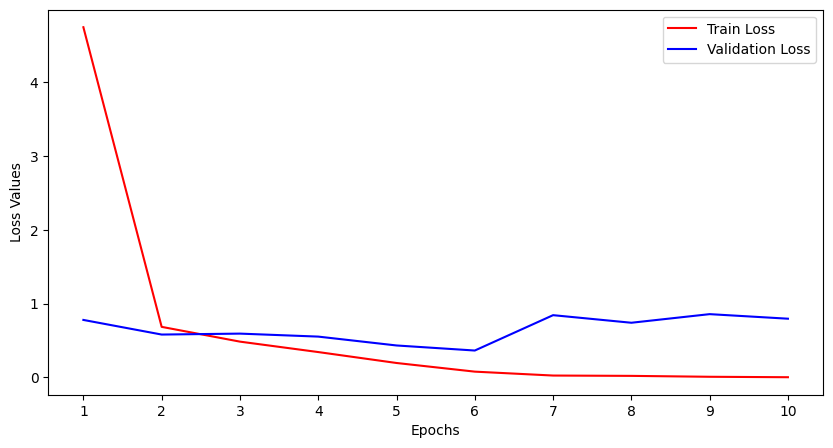

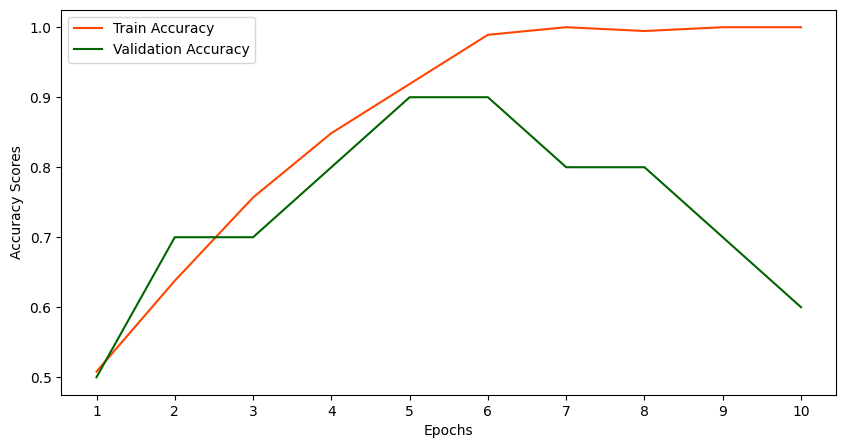

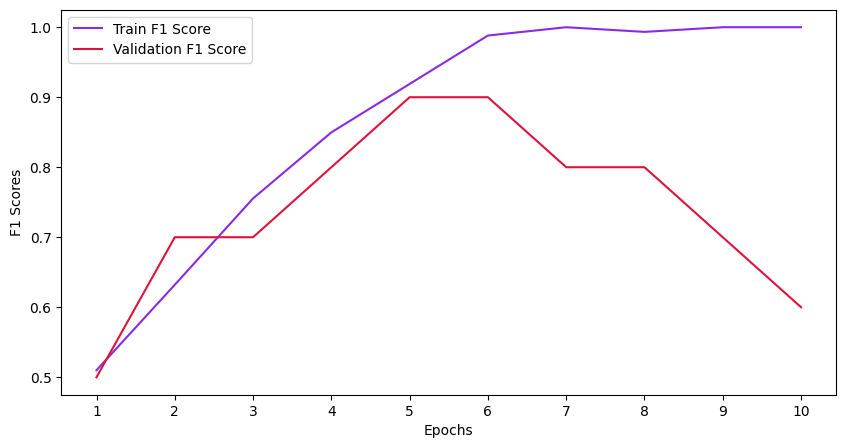

In [20]:
class PlotLearningCurves:

    def __init__(self, tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s):

        self.tr_losses, self.val_losses, self.tr_accs, self.val_accs, self.tr_f1s, self.val_f1s = tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s

    def plot(self, array_1, array_2, label_1, label_2, color_1, color_2):

        plt.plot(array_1, label = label_1, c = color_1); plt.plot(array_2, label = label_2, c = color_2)

    def create_figure(self): plt.figure(figsize = (10, 5))

    def decorate(self, ylabel, xlabel = "Epochs"):

        plt.xlabel(xlabel); plt.ylabel(ylabel)
        plt.xticks(ticks = np.arange(len(self.tr_accs)), labels = [i for i in range(1, len(self.tr_accs) + 1)])
        plt.legend(); plt.show()

    def visualize(self):

        # Figure 1
        self.create_figure()
        self.plot(array_1 = self.tr_losses, array_2 = self.val_losses, label_1 = "Train Loss", label_2 = "Validation Loss", color_1 = "red", color_2 = "blue"); self.decorate(ylabel = "Loss Values")

        # Figure 2
        self.create_figure()
        self.plot(array_1 = self.tr_accs, array_2 = self.val_accs, label_1 = "Train Accuracy", label_2 = "Validation Accuracy", color_1 = "orangered", color_2 = "darkgreen")
        self.decorate(ylabel = "Accuracy Scores")

        # Figure 3
        self.create_figure()
        self.plot(array_1 = [tr_f1.cpu() for tr_f1 in self.tr_f1s], array_2 = [vl_f1.cpu() for vl_f1 in self.val_f1s], label_1 = "Train F1 Score", label_2 = "Validation F1 Score", color_1 = "blueviolet", color_2 = "crimson"); self.decorate(ylabel = "F1 Scores")

PlotLearningCurves(tr_losses, val_losses, tr_accs, val_accs, tr_f1s, val_f1s).visualize()
